__Arturo Rodriguez__
# Development and Analysis of an Unsupervised Model
### Instructions
1. Filter the data to only include “Pain Management” provider types and providers within the state of California (“CA”).
2. Develop an unsupervised model to identify different clusters of Pain Management providers based on their HCPCS and beneficiary utilization information.
3. Identify providers that appear to be in outlier clusters and explain why.
4. Exploratory analysis, model development, and model explanation are left to the discretion of the applicant.

### Assessment
The script developed by the applicant will be assessesd for:
-  __Data pre-processing__
-  __Model selection and development__
-  __Interpretation of results__

In [1]:
import numpy as np
import pandas as pd # using version 0.24.1
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import data
#df = pd.read_csv('Medicare_Provider_Util_Payment_PUF_CY2015.txt', sep = '\t')

# Let's filter as requested:
#df = df[ (df['provider_type'] == 'Pain Management') & (df['nppes_provider_state'] == 'CA') ]
#df.reset_index(inplace = True)

In [3]:
df = pd.read_csv('ex2.csv', index_col=0)
df.reset_index(inplace = True)
# DELETE THIS AT THE END

In [4]:
df.head(3)

,index,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,12454,1003077157,SNIDERMAN,MICHAEL,I,MD,M,I,1500 SAN PABLO ST,NaN,...,00790,Anesthesia for procedure in upper abdomen incl...,N,11.0,11.0,11.0,390.468182,2102.272727,294.077273,278.408182
1,12455,1003077157,SNIDERMAN,MICHAEL,I,MD,M,I,1500 SAN PABLO ST,NaN,...,00840,Anesthesia for procedure in lower abdominal ca...,N,14.0,14.0,14.0,317.600000,1700.892857,248.997857,235.965000
2,12456,1003077157,SNIDERMAN,MICHAEL,I,MD,M,I,1500 SAN PABLO ST,NaN,...,27096,Injection procedure into sacroiliac joint for ...,N,14.0,13.0,14.0,116.979286,520.000000,89.853571,63.917143


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 27 columns):
index                               2547 non-null int64
npi                                 2547 non-null int64
nppes_provider_last_org_name        2547 non-null object
nppes_provider_first_name           2547 non-null object
nppes_provider_mi                   1841 non-null object
nppes_credentials                   2543 non-null object
nppes_provider_gender               2547 non-null object
nppes_entity_code                   2547 non-null object
nppes_provider_street1              2547 non-null object
nppes_provider_street2              1525 non-null object
nppes_provider_city                 2547 non-null object
nppes_provider_zip                  2547 non-null float64
nppes_provider_state                2547 non-null object
nppes_provider_country              2547 non-null object
provider_type                       2547 non-null object
medicare_participation_indicator    254

In [6]:
df.nunique()

index                               2547
npi                                  157
nppes_provider_last_org_name         146
nppes_provider_first_name            120
nppes_provider_mi                     21
nppes_credentials                     13
nppes_provider_gender                  2
nppes_entity_code                      1
nppes_provider_street1               144
nppes_provider_street2                76
nppes_provider_city                   87
nppes_provider_zip                   145
nppes_provider_state                   1
nppes_provider_country                 1
provider_type                          1
medicare_participation_indicator       1
place_of_service                       2
hcpcs_code                           258
hcpcs_description                    250
hcpcs_drug_indicator                   2
line_srvc_cnt                        546
bene_unique_cnt                      297
bene_day_srvc_cnt                    494
average_Medicare_allowed_amt        2433
average_submitte

In [7]:
df[['npi','hcpcs_code', 'hcpcs_description', 'hcpcs_drug_indicator', 'bene_unique_cnt', 'bene_day_srvc_cnt']].head(3)

,npi,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,bene_unique_cnt,bene_day_srvc_cnt
0,1003077157,00790,Anesthesia for procedure in upper abdomen incl...,N,11.0,11.0
1,1003077157,00840,Anesthesia for procedure in lower abdominal ca...,N,14.0,14.0
2,1003077157,27096,Injection procedure into sacroiliac joint for ...,N,13.0,14.0


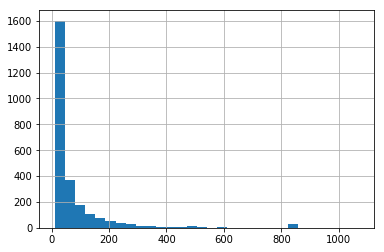

In [8]:
df['bene_ratio'] = df['bene_day_srvc_cnt']/df['bene_unique_cnt']
df = df[['npi','hcpcs_code', 'hcpcs_drug_indicator', 'bene_unique_cnt', 'bene_ratio']]
df.bene_unique_cnt.hist(bins=30)

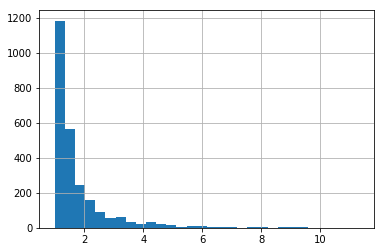

In [9]:
df.bene_ratio.hist(bins=30)

In [10]:
df.head(3)

,npi,hcpcs_code,hcpcs_drug_indicator,bene_unique_cnt,bene_ratio
0,1003077157,00790,N,11.0,1.000000
1,1003077157,00840,N,14.0,1.000000
2,1003077157,27096,N,13.0,1.076923


In [11]:
df['hcpcs_drug_indicator'] = df['hcpcs_drug_indicator'].map({'N':0, 'Y':1})

# Let's make dummy variables of 'hcpcs_code'
dummy = pd.get_dummies(df['hcpcs_code'], drop_first = True)

df.drop('hcpcs_code', axis = 1, inplace = True)

df = pd.concat([df, dummy], axis = 1)

df = df.groupby('npi').mean()

columns = df.columns
npi = df.index
df.head(3)

,hcpcs_drug_indicator,bene_unique_cnt,bene_ratio,00400,00630,00740,00790,00810,00840,01214,...,J3490,J7321,J7323,J7324,J7325,Q2037,Q9962,Q9965,Q9966,Q9967
npi,,,,,,,,,,,,,,,,,,,,,
1003077157,0.0,32.300000,1.287793,0.0,0.0,0.0,0.1,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013008481,0.0,39.647059,1.327610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013085976,0.0,49.000000,2.328438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Let's normalize the data
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.set_index(npi, inplace=True)
df.columns = columns
df.head(3)

,hcpcs_drug_indicator,bene_unique_cnt,bene_ratio,00400,00630,00740,00790,00810,00840,01214,...,J3490,J7321,J7323,J7324,J7325,Q2037,Q9962,Q9965,Q9966,Q9967
npi,,,,,,,,,,,,,,,,,,,,,
1003077157,0.0,0.064789,0.042431,0.0,0.0,0.0,0.5,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013008481,0.0,0.091530,0.048301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013085976,0.0,0.125573,0.195859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
labels = kmeans.labels_

from collections import Counter
Counter(labels)

Counter({0: 50, 1: 2, 2: 105})

In [14]:
# Let's add the cluster at the beginning of the dataframe
df['cluster'] = labels
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

df.head(3)

,cluster,hcpcs_drug_indicator,bene_unique_cnt,bene_ratio,00400,00630,00740,00790,00810,00840,...,J3490,J7321,J7323,J7324,J7325,Q2037,Q9962,Q9965,Q9966,Q9967
npi,,,,,,,,,,,,,,,,,,,,,
1003077157,2,0.0,0.064789,0.042431,0.0,0.0,0.0,0.5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013008481,0,0.0,0.091530,0.048301,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1013085976,2,0.0,0.125573,0.195859,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df[df.cluster == 1]

,cluster,hcpcs_drug_indicator,bene_unique_cnt,bene_ratio,00400,00630,00740,00790,00810,00840,...,J3490,J7321,J7323,J7324,J7325,Q2037,Q9962,Q9965,Q9966,Q9967
npi,,,,,,,,,,,,,,,,,,,,,
1245228766,1,0.380435,0.187687,0.091566,0.0,0.0,0.0,0.0,0.0,0.0,...,0.217391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1275625204,1,0.357143,0.202306,0.162844,0.0,0.0,0.0,0.0,0.0,0.0,...,0.204082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df.groupby('cluster').mean()

,hcpcs_drug_indicator,bene_unique_cnt,bene_ratio,00400,00630,00740,00790,00810,00840,01214,...,J3490,J7321,J7323,J7324,J7325,Q2037,Q9962,Q9965,Q9966,Q9967
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.163239,0.191710,0.094492,0.000000,0.000000,0.005263,0.000000,0.000000,0.000000,0.000000,...,0.102239,0.000000,0.006176,0.020000,0.02,0.000000,0.02,0.007857,0.009480,0.025294
1,0.368789,0.194997,0.127205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.210736,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000
2,0.160188,0.139202,0.142051,0.020295,0.009524,0.025741,0.018254,0.025685,0.009524,0.009524,...,0.054672,0.019672,0.009524,0.008416,0.00,0.009524,0.00,0.013889,0.020745,0.014831


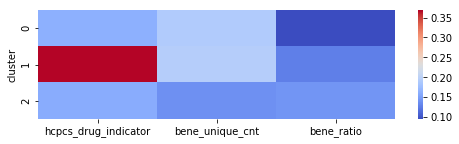

In [17]:
plt.figure(figsize=(8,2))
sns.heatmap(df.groupby('cluster').mean()[['hcpcs_drug_indicator', 'bene_unique_cnt', 'bene_ratio']],
           cmap='coolwarm')

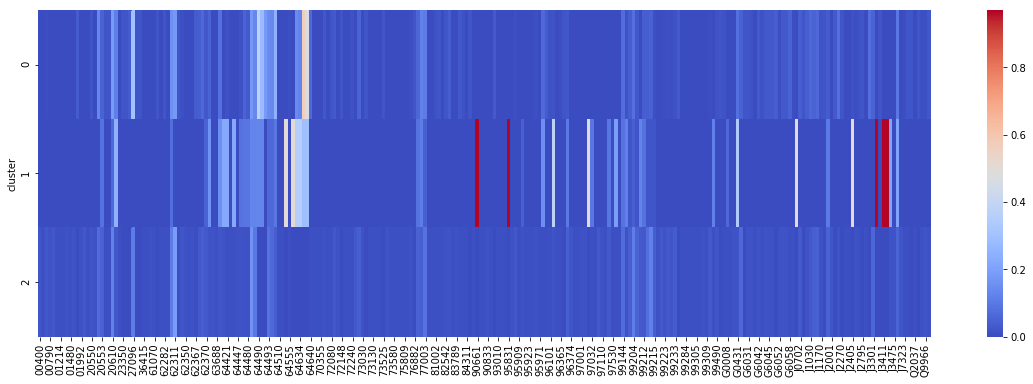

In [18]:
plt.figure(figsize=(20,6))
sns.heatmap(df.groupby('cluster').mean().drop(['hcpcs_drug_indicator', 'bene_unique_cnt', 'bene_ratio'], axis=1),
           cmap='coolwarm')